# EDA of Melanoma Metadata and Images







In [31]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import plotly.express as px
import os
import random
import re
import math
import time
import warnings

warnings.filterwarnings('ignore') # Disabling warnings for clearer outputs

seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)

In [32]:
# Setting file paths for our notebook:

base_path = '/kaggle/input/siim-isic-melanoma-classification'
img_stats_path = '/kaggle/input/melanoma2020imgtabular'

In [33]:
# Loading train and test data.
train = pd.read_csv(os.path.join(base_path, 'train.csv'))
print(
    f'Train data has {train.shape[1]} features, {train.shape[0]} observations.\nTrain features are:\n{train.columns.tolist()}'
)

Train data has 8 features, 33126 observations.
Train features are:
['image_name', 'patient_id', 'sex', 'age_approx', 'anatom_site_general_challenge', 'diagnosis', 'benign_malignant', 'target']


In [34]:
# Renaming train/test columns:
train.columns = [
    'img_name', 'id', 'sex', 'age', 'location', 'diagnosis',
    'benign_malignant', 'target'
]


# Missing Values

In [35]:
# Checking missing values:
def missing_percentage(df):

    total = df.isnull().sum().sort_values(
        ascending=False)[df.isnull().sum().sort_values(ascending=False) != 0]
    percent = (df.isnull().sum().sort_values(ascending=False) / len(df) *
               100)[(df.isnull().sum().sort_values(ascending=False) / len(df) *
                     100) != 0]
    return pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])

missing_train = missing_percentage(train)
print(missing_train)

          Total   Percent
location    527  1.590895
age          68  0.205277
sex          65  0.196220


# Variable distribution
Checking variable distribution between imputing missing values

<AxesSubplot:title={'center':'Gender Distribution'}, xlabel='sex', ylabel='count'>

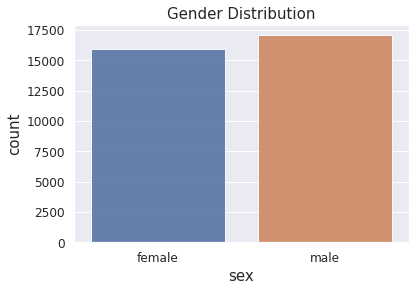

In [36]:
plt.title('Gender Distribution', size=15)
plt.xlabel('Sex', size=15)
plt.ylabel('Count', size=15)
sns.countplot(train.sex.sort_values(ignore_index=True),
              alpha=0.9)

<AxesSubplot:title={'center':'Image location Distribution'}, xlabel='location', ylabel='count'>

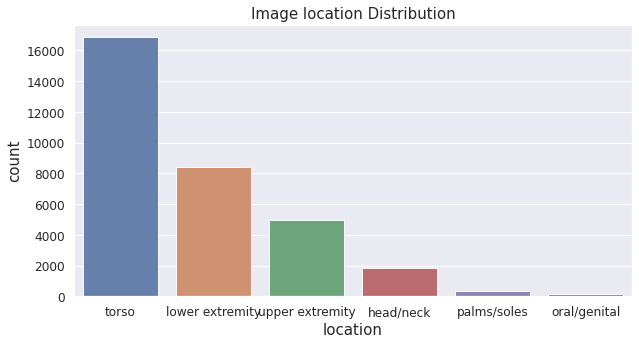

In [37]:
plt.figure(figsize=(10, 5))
plt.title('Image location Distribution', size=15)
plt.xlabel('Location', size=15)
plt.ylabel('Count', size=15)
sns.countplot(train.location,
              alpha=0.9,              
              order=train['location'].value_counts().index)


<AxesSubplot:title={'center':'Age Distribution'}, xlabel='age', ylabel='count'>

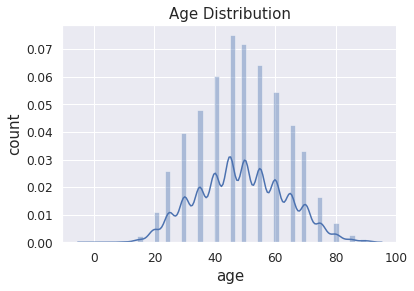

In [38]:
plt.title('Age Distribution', size=15)
plt.xlabel('age', size=15)
plt.ylabel('count', size=15)
# Plot the histogram.
sns.distplot(train.age)

# Imputing Missing Data

Treating missing values of location column by unknown, sex by mode of the variable distribution, age by median of the variable distribution

In [39]:
# Filling missing anatom site values with 'unknown' tag:
train['location'].fillna('unknown', inplace=True)
# Filling age and sex with appropriate values.
train['sex'].fillna(train['sex'].mode()[0], inplace=True)
train['age'].fillna(train['age'].median(), inplace=True)
# Checking missing value counts:
print(
    f'Train missing value count: {train.isnull().sum().sum()}'
)

Train missing value count: 0


# Exploratory Data Analysis

## Scans by Anatomy Site

* 80% lesions are found on the torso, followed by lower and upper extremity
* Head/neck and oral show least number of images from patients


In [40]:
# Train data:
cntstr = train.location.value_counts().rename_axis('location').reset_index(
    name='count')

fig = px.treemap(cntstr,
                 path=['location'],
                 values='count',
                 color='count',
                 color_continuous_scale='YlGnBu',
                 title='Scans by Anatomy Site')

fig.update_traces(textinfo='label+percent entry')
fig.show()

# Body Part Ratio by Gender and Target

* Head/neck shows most malignant ratio followed by oral/genital and upper extremity. 
* Scanned body part locations are similar in order between males and females with small differences on distribution.


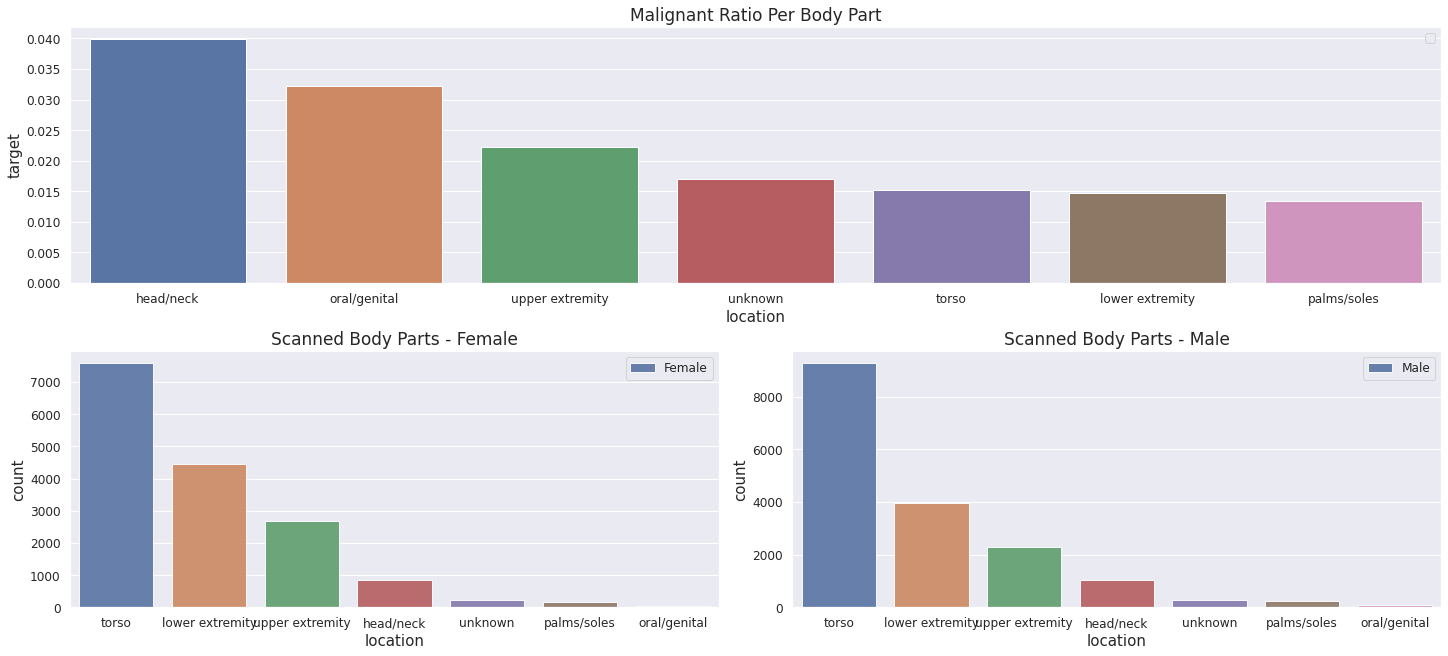

In [41]:
# Creating a customized chart and giving in figsize etc.

fig = plt.figure(constrained_layout=True, figsize=(20, 9))
# Creating a grid
grid = gridspec.GridSpec(ncols=4, nrows=2, figure=fig)

# Customizing the first grid.

ax1 = fig.add_subplot(grid[1, :2])
# Set the title.
ax1.set_title('Scanned Body Parts - Female', size=17)

# Plot:

sns.countplot(
    train[train['sex'] == 'female'].location.sort_values(ignore_index=True),
    alpha=0.9,
    ax=ax1,
#     color='#fdc029',
    label='Female',
    order=train['location'].value_counts().index)
ax1.set_xlabel('location', size=15)
ax1.set_ylabel('count', size=15)
ax1.legend()

# Customizing the second grid.

ax2 = fig.add_subplot(grid[1, 2:])

# Set the title.

ax2.set_title('Scanned Body Parts - Male', size=17)

# Plot.

sns.countplot(
    train[train['sex'] == 'male'].location.sort_values(ignore_index=True),
    alpha=0.9,
    ax=ax2,
    label='Male',
    order=train['location'].value_counts().index)
ax2.set_xlabel('location', size=15)
ax2.set_ylabel('count', size=15)
ax2.legend()

# Customizing the third grid.

ax3 = fig.add_subplot(grid[0, :])

# Set the title.

ax3.set_title('Malignant Ratio Per Body Part', size=17)

# Plot.

loc_freq = train.groupby('location')['target'].mean().sort_values(
    ascending=False)
sns.barplot(x=loc_freq.index, y=loc_freq, ax=ax3)
ax3.set_xlabel('location', size=15)
ax3.set_ylabel('target', size=15)
ax3.legend()
plt.show()

# Sunburst chart

* Only 2% of our targets are malignant
* On malignant images males are dominant with 62% 
* Gender wise benign images are more balance 52-48% male female ratio
* Malignant image scan locations differ based on the patient's gender
* The torso is most common location in males and females
* Lower extremity is more common with female scans than males 18% males vs 26% females
* Upper extremity malignant scans is common with females than males (23- 17%)


In [55]:
# Plotting interactive sunburst:

fig = px.sunburst(data_frame=train,
                  path=['benign_malignant', 'sex', 'location'],
                  color='sex',
                  color_discrete_sequence=px.colors.qualitative.Prism,
#                     color_continuous_scale='YlGnBu',

                  maxdepth=-1,
                  title='Sunburst Chart Benign/Malignant > Sex > Location')

fig.update_traces(textinfo='label+percent parent')
fig.update_layout(margin=dict(t=0, l=0, r=0, b=0))
fig.show()

# Age and Scan Result Relations

Age looks pretty decent factor on scan result. Getting malignant scan result with elderly age is more possible than young patients. There is spike for both genders after age of 85, if we look distribution of ages there isn't much of 80+ patients and it can be the reason of this spike but we can safely say it's more likely to be malignant scan after age of 60. We see small bump on age 15-20 for females, again it depends on the scan numbers but still, poor souls...

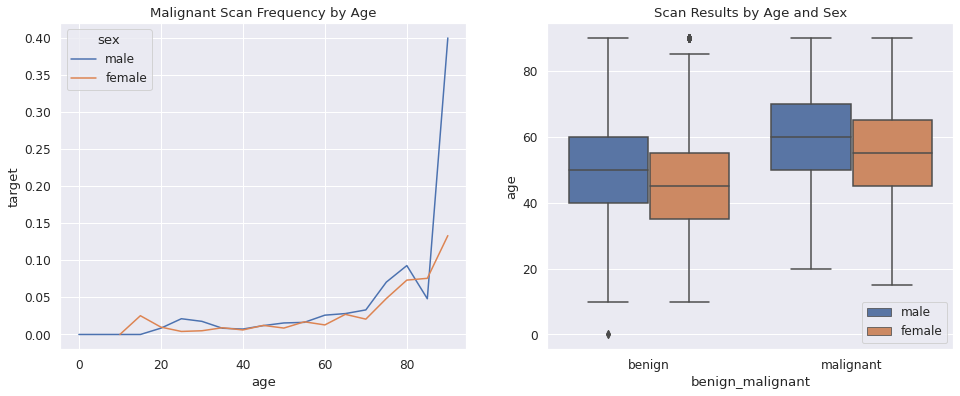

In [43]:
# Plotting age vs sex vs target:

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
sns.lineplot(x='age',
             y='target',
             data=train,
             ax=ax[0],
             hue='sex',
#              palette=orange_black[:2],
             ci=None)
sns.boxplot(x='benign_malignant',
            y='age',
            data=train,
            ax=ax[1],
            hue='sex',
#             palette=orange_black
           )

plt.legend(loc='lower right')

ax[0].set_title('Malignant Scan Frequency by Age')
ax[1].set_title('Scan Results by Age and Sex')

plt.show()

# Age distribution by scan outcome and gender

* Patients above age 50 have more malignant observations


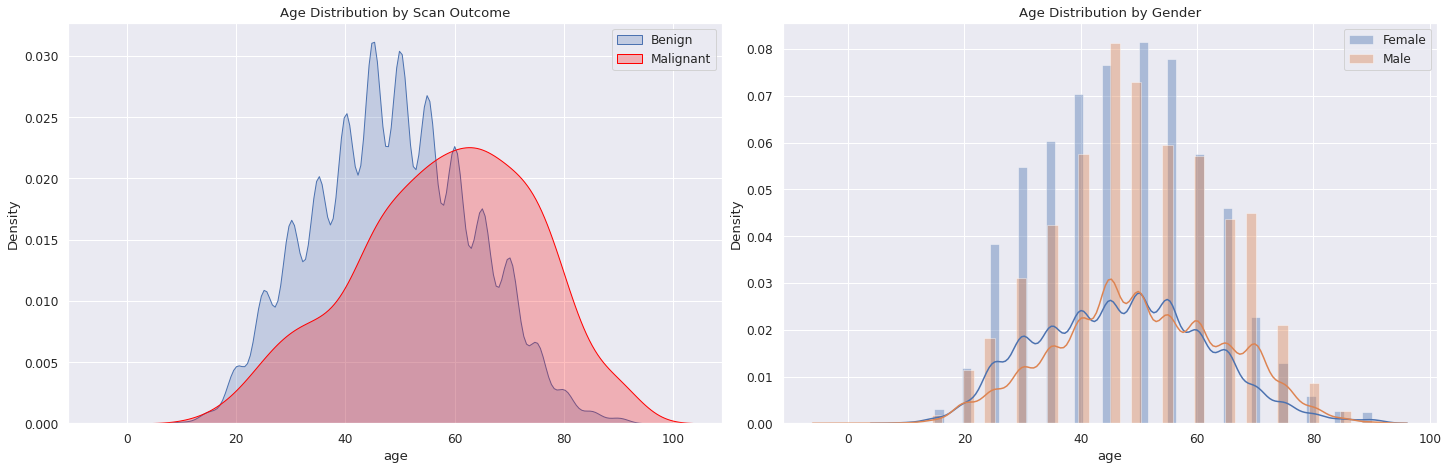

In [44]:
# Creating a customized chart and giving in figsize etc.

# Plotting age dist vs target and age dist vs datasets

fig = plt.figure(constrained_layout=True, figsize=(20, 12))

# Creating a grid

grid = gridspec.GridSpec(ncols=4, nrows=2, figure=fig)

# Customizing the first grid.

ax1 = fig.add_subplot(grid[0, :2])

# Set the title.

ax1.set_title('Age Distribution by Scan Outcome')

# Plot


sns.kdeplot(train[train['target'] == 0]['age'],
            shade=True,
            ax=ax1,
            label='Benign')
sns.kdeplot(train[train['target'] == 1]['age'],
            shade=True,
            ax=ax1,
            color='red',
            label='Malignant')
ax1.legend()


# Customizing second grid.

ax2 = fig.add_subplot(grid[0, 2:])

# Set the title.

ax2.set_title('Age Distribution by Gender')

# Plot

sns.distplot(train[train.sex == 'female'].age,
             ax=ax2,
             label='Female',
            )
sns.distplot(train[train.sex == 'male'].age,
             ax=ax2,
             label='Male',
            )
ax2.legend()

plt.show()

# Unique Patients and Their Scan Images

* Most of the malignant results are found around first 20 scans
* In general we can say it's more likely to be malignant result if there are more scan images
* 2056 unique patient IDs, with 33K images
* 30% patients have between 2-5 images


In [45]:
print( f'Number of unique Patient ID\'s in train set: {train.id.nunique()}, Total: {train.id.count()}')

Number of unique Patient ID's in train set: 2056, Total: 33126


In [46]:
train['age_min'] = train['id'].map(train.groupby(['id']).age.min())
train['age_max'] = train['id'].map(train.groupby(['id']).age.max())
train['n_images'] = train.id.map(train.groupby(['id']).img_name.count())

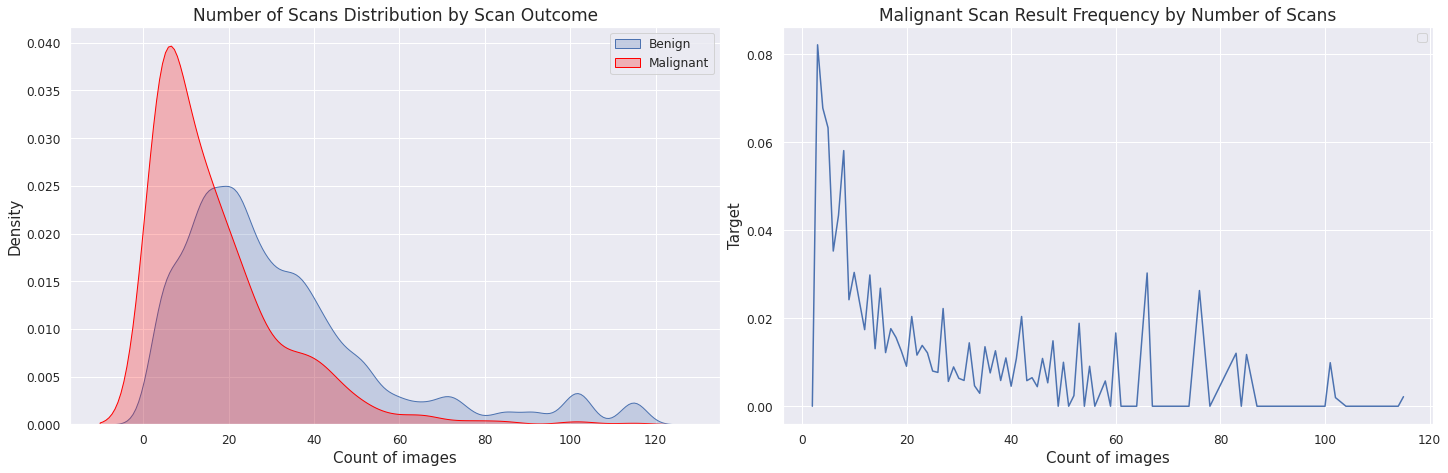

In [48]:
# Creating a customized chart and giving in figsize etc.

fig = plt.figure(constrained_layout=True, figsize=(20, 12))

# Creating a grid

grid = gridspec.GridSpec(ncols=4, nrows=2, figure=fig)

# Customizing the first grid.

ax1 = fig.add_subplot(grid[0, :2])

# Set the title.

ax1.set_title('Number of Scans Distribution by Scan Outcome', size=17)

# Plot

sns.kdeplot(train[train['target'] == 0]['n_images'],
            shade=True,
            ax=ax1,
            label='Benign')
sns.kdeplot(train[train['target'] == 1]['n_images'],
            shade=True,
            ax=ax1,
            label='Malignant', color='red')
ax1.set_xlabel('Count of images', size=15)
ax1.set_ylabel('Density', size=15)
ax1.legend()

# Customizing the second grid.

ax2 = fig.add_subplot(grid[0, 2:])
ax2.set_xlabel('Count of images', size=15)
ax2.set_ylabel('Target', size=15)

# Set the title.

ax2.set_title('Malignant Scan Result Frequency by Number of Scans', size=17)

# Plot

z = train.groupby('n_images')['target'].mean()
sns.lineplot(x=z.index, y=z, ax=ax2)
ax2.legend()

plt.show()

# Diagnosis Distribution

This part we can't use in our model but it's giving us some insights about this disease so we can inspect that too

In [49]:
diag = train.diagnosis.value_counts()
fig = px.pie(diag,
             values='diagnosis',
             names=diag.index,
             color_discrete_sequence=px.colors.qualitative.Prism,

             hole=.4)
fig.update_traces(textinfo='percent+label', pull=0.05)
fig.show()

# Loading Image Meta Features

In [50]:
# Loading color data:
train_attr = pd.read_csv(
    os.path.join(img_stats_path, 'train_mean_colorres.csv'))
train = pd.concat([train, train_attr], axis=1)

train['res'] = train['width'].astype(str) + 'x' + train['height'].astype(str)
train_attr.head()

# Image Colors and Their Effects on Results

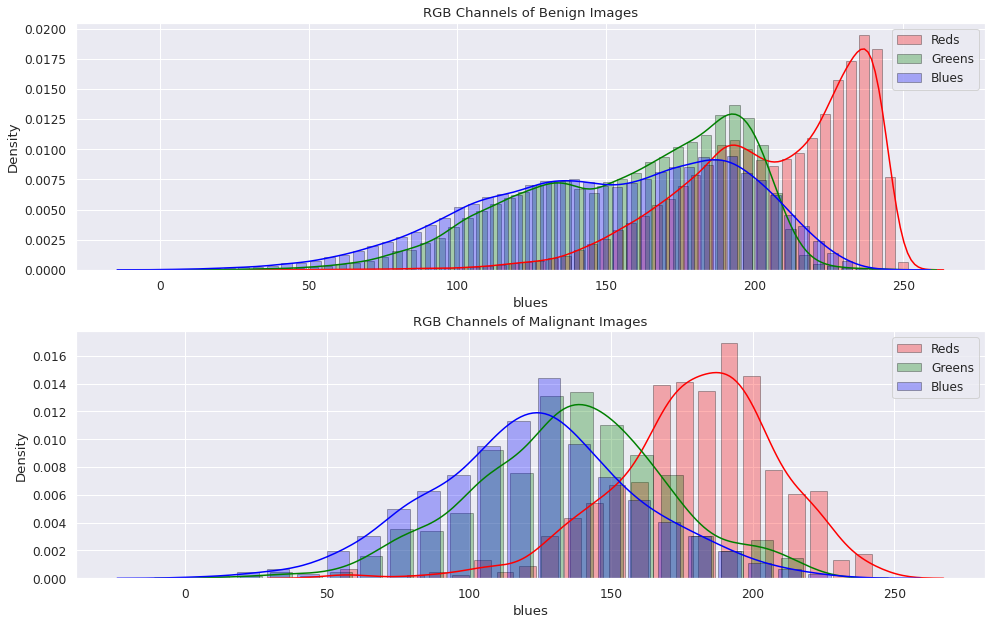

In [53]:
# Creating a customized chart and giving in figsize etc.

fig = plt.figure(constrained_layout=True, figsize=(20, 12))

# Creating a grid

grid = gridspec.GridSpec(ncols=3, nrows=3, figure=fig)

# Customizing the first grid.

ax1 = fig.add_subplot(grid[0, :2])

# Set the title.

ax1.set_title('RGB Channels of Benign Images')

# Plot.

sns.distplot(train[train['target'] == 0].reds,
             hist_kws={
                 'rwidth': 0.75,
                 'edgecolor': 'black',
                 'alpha': 0.3
             },
             color='red',
             kde=True,
             ax=ax1,
             label='Reds')
sns.distplot(train[train['target'] == 0].greens,
             hist_kws={
                 'rwidth': 0.75,
                 'edgecolor': 'black',
                 'alpha': 0.3
             },
             color='green',
             kde=True,
             ax=ax1,
             label='Greens')
sns.distplot(train[train['target'] == 0].blues,
             hist_kws={
                 'rwidth': 0.75,
                 'edgecolor': 'black',
                 'alpha': 0.3
             },
             color='blue',
             kde=True,
             ax=ax1,
             label='Blues')

ax1.legend()

# Customizing the second grid.

ax2 = fig.add_subplot(grid[1, :2])

# Set the title.

ax2.set_title('RGB Channels of Malignant Images')

# Plot

sns.distplot(train[train['target'] == 1].reds,
             hist_kws={
                 'rwidth': 0.75,
                 'edgecolor': 'black',
                 'alpha': 0.3
             },
             color='red',
             kde=True,
             ax=ax2,
             label='Reds')
sns.distplot(train[train['target'] == 1].greens,
             hist_kws={
                 'rwidth': 0.75,
                 'edgecolor': 'black',
                 'alpha': 0.3
             },
             color='green',
             kde=True,
             ax=ax2,
             label='Greens')
sns.distplot(train[train['target'] == 1].blues,
             hist_kws={
                 'rwidth': 0.75,
                 'edgecolor': 'black',
                 'alpha': 0.3
             },
             color='blue',
             kde=True,
             ax=ax2,
             label='Blues')
ax2.legend()
plt.show()